In [248]:
from matplotlib import pyplot as plt 
import numpy as np 
import pickle as pkl
import os
from scipy.stats import spearmanr
import pandas as pd
from sklearn.metrics import roc_auc_score

import sys 
sys.path.append('../src/')
from utils import load_config, get_corruption_scores

# Load results

In [249]:
out_dir = '../results/exp3-2'

res = pd.read_csv(f'{out_dir}/results.csv', sep='\t')
res.tail()

,uid,config,config-checksum,method,perf_filter_low,perf_filter_high,runtime_s
10,089ff69c-76b3-4c19-8ad5-913f8018604a,../configs/exp3.py,58be40ecab0c2d25e559ccd8b6c8bb33,dvrl,"[0.7818333333333335, 0.7928333333333333, 0.782...","[0.789, 0.7206666666666667, 0.6418333333333334...",766.906617
11,44f0c9b2-e92b-4c37-bad2-8731b7ed7997,../configs/exp3.py,58be40ecab0c2d25e559ccd8b6c8bb33,random,"[0.7813333333333333, 0.771, 0.7681666666666667...","[0.7741666666666666, 0.773, 0.77, 0.7613333333...",200.374042
12,f818090a-f8fe-472d-aab5-cd79ced04a97,../configs/exp3.py,58be40ecab0c2d25e559ccd8b6c8bb33,dvgs,"[0.8006666666666667, 0.8206666666666665, 0.829...","[0.7935, 0.7806666666666667, 0.760166666666666...",303.772316
13,3b6165a7-24ee-4c93-b8eb-63c0c89c0936,../configs/exp3.py,58be40ecab0c2d25e559ccd8b6c8bb33,dvrl,"[0.7753333333333333, 0.7815, 0.801333333333333...","[0.7676666666666666, 0.7108333333333333, 0.626...",765.637851
14,39df9199-705f-45fa-a735-d8296c8e4cf6,../configs/exp3.py,58be40ecab0c2d25e559ccd8b6c8bb33,random,"[0.786, 0.782, 0.7815, 0.7666666666666666, 0.7...","[0.7818333333333333, 0.7841666666666667, 0.777...",190.938690


In [250]:
vals_dict = {uid:
                {
                 'vals':np.load(f'{out_dir}/data_values/{uid}/data_values.npy', allow_pickle=True), 
                 'exog':np.load(f'{out_dir}/data_values/{uid}/exog_noise.npy', allow_pickle=True),
                 'endog':np.load(f'{out_dir}/data_values/{uid}/endog_noise.npy', allow_pickle=True)
                } 
            for uid in res.uid.values}

In [251]:
# check that all config-checksums are identical; if not, it may have changed between runs 
if res['config-checksum'].unique().shape[0] > 1: 
    print('WARNING! config checksums are not identical, config file may have changed between runs.')

# check that the same config file was used 
if res['config'].unique().shape[0] > 1: 
    print('WARNING! Different config. files were used between runs.')

In [252]:
config = load_config(res.config.values[0])

Using cache found in /home/teddy/.cache/torch/hub/pytorch_vision_v0.10.0


# corrupted label identification 

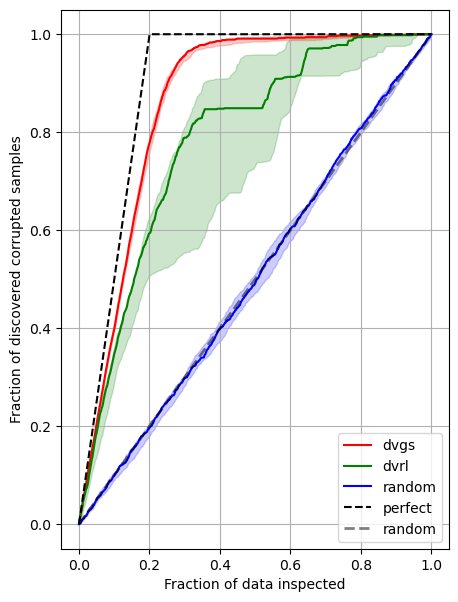

In [253]:
auroc = {m:[] for m in res.method.unique()}

plt.figure(figsize=(5, 7))

for method, c in zip(res.method.unique(), ['r', 'g', 'b', 'm', 'c']): 

    _temp = res[lambda x: x.method == method]
    
    pp_corr = []
    for i,row in _temp.iterrows(): 

        noise_labels = vals_dict[row.uid]['endog']
        noise_idx = noise_labels.nonzero()[0]
        vals = vals_dict[row.uid]['vals']

        auroc[method].append(roc_auc_score(noise_labels, -vals))

        pk, p_corr, p_perfect, p_random = get_corruption_scores(vals, noise_idx, config.train_num, config.endog_noise)
        pp_corr.append(p_corr)

    pp_corr = np.stack(pp_corr, axis=0)

    plt.plot(pk, np.quantile(a=pp_corr, q=0.5, axis=0), color=c, label=method)
    plt.fill_between(pk, np.quantile(a=pp_corr, q=0.05, axis=0), np.quantile(a=pp_corr, q=0.95, axis=0), color=c, alpha=0.2)

plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'k--', label='random', linewidth=2, alpha=0.5)

plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(visible=None)
plt.savefig(out_dir + '/label_corrupt_01.png', dpi=300)
plt.show()


In [254]:
table_latex = [[config.dataset]]
for method in ['dvgs', 'dshap', 'dvrl', 'loo', 'random']: 
    if method in auroc: 
        table_latex.append( [f'{np.mean(auroc[method]):.3f} $\pm$ {2*np.std(auroc[method]):.3f}'] )
    else: 
        table_latex.append(['NA'])

table_latex = pd.DataFrame(table_latex).T 
table_latex.columns= ['Dataset', 'dvgs', 'dshap', 'dvrl', 'loo', 'random']

print()
#table_latex.style.to_latex()

In [255]:
table_latex

,Dataset,dvgs,dshap,dvrl,loo,random
0,cifar10,0.954 $\pm$ 0.009,NA,0.835 $\pm$ 0.110,NA,0.499 $\pm$ 0.019


In [256]:
table_latex.to_csv(out_dir + '/label_corrupt_auroc.csv')

# Filtered Data Performance

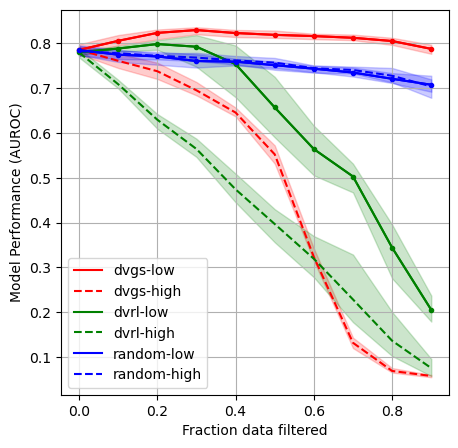

In [257]:
f, ax = plt.subplots(1,1, figsize=(5, 5))

for method, c in zip(res.method.unique(), ['r', 'g', 'b', 'm', 'c']): 

    _temp = res[lambda x: x.method == method]
    
    _low = [] 
    _high = [] 
    for i,row in _temp.iterrows(): 
        _low.append(row.perf_filter_low.strip('[]').split(','))
        _high.append(row.perf_filter_high.strip('[]').split(','))

    _low = np.stack(_low, axis=0).astype(float)
    _high = np.stack(_high, axis=0).astype(float)

    plt.plot(config.filter_kwargs['qs'], _low.mean(axis=0), color=c, label=f'{method}-low', linestyle='-')
    plt.plot(config.filter_kwargs['qs'], _low.mean(axis=0), color=c, marker='.')
    plt.fill_between(config.filter_kwargs['qs'], np.quantile(a=_low, q=0.05, axis=0), np.quantile(a=_low, q=0.95, axis=0), color=c, alpha=.2)

    plt.plot(config.filter_kwargs['qs'], _high.mean(axis=0), color=c, linestyle='--', label=f'{method}-high')
    #plt.plot(config.filter_kwargs['qs'], _high.mean(axis=0), color=c, marker='.', linestyle=None)
    plt.fill_between(config.filter_kwargs['qs'], np.quantile(a=_high, q=0.05, axis=0), np.quantile(a=_high, q=0.95, axis=0), color=c, alpha=.2)


plt.legend()
plt.xlabel('Fraction data filtered')
plt.ylabel('Model Performance (AUROC)')
plt.grid(visible=None)
plt.savefig(out_dir + '/label_corrupt_02.png', dpi=300)
plt.show()